In [234]:
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

#### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

### Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.


In [235]:
query = """
            select title, rental_duration, rental_rate, length, replacement_cost, rating, category, rented_may
            from(
            select film_id,
            case
            when month(rental_date) = 5 then True
            else False
            end as rented_may
            from rental
            join inventory using(inventory_id)
            join film using(film_id)
            join film_category using(film_id)
            join category using (category_id)
            where year(rental_date) = 2005 and month(rental_date) = 5
            group by film_id) t1
            right join(
            select rental_date, title, film_id, rental_duration, rental_rate, length, replacement_cost, rating, category.name as category
            from rental
            join inventory using(inventory_id)
            join film using(film_id)
            join film_category using(film_id)
            join category using (category_id)
            where year(rental_date) = 2005
            group by film_id
            ) t2
            using (film_id)
            order by title asc
"""

#### Read the data into a Pandas dataframe.


In [236]:
df = pd.read_sql_query(query, engine)
df.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,category,rented_may
0,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,Documentary,1.0
1,ACE GOLDFINGER,3,4.99,48,12.99,G,Horror,NaN
2,ADAPTATION HOLES,7,2.99,50,18.99,NC-17,Documentary,1.0
3,AFFAIR PREJUDICE,5,2.99,117,26.99,G,Horror,1.0
4,AFRICAN EGG,6,2.99,130,22.99,G,Family,1.0


In [237]:
df.shape

(958, 8)

#### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


In [238]:
# df.replacement_cost.value_counts()

In [239]:
# Has to be categorized
# df.rental_duration.value_counts()

In [240]:
# Has to be categorized
# df.rental_rate.value_counts()

In [241]:
# np.mean(df.length)

In [242]:
# BINING THE MOVIES
# df.length.value_counts()

In [243]:
# We don´t think is usefull now, but we´ll keep it
# df.title.value_counts()

In [244]:
df.isna().sum()

title                 0
rental_duration       0
rental_rate           0
length                0
replacement_cost      0
rating                0
category              0
rented_may          272
dtype: int64

In [245]:
# The Nan´s in rented_may represent all the films that were not rented in May. 
# Since it is a boolean datatype we need to convert the Nan´s to 0.

In [246]:
df['rented_may'] = df['rented_may'].fillna(0)

In [247]:
df.isna().sum()

title               0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
category            0
rented_may          0
dtype: int64

### Steps to follow

+ Columns to categorical encode: title, category, rating, rental_rate, rental_duration
+ Columns to drop: replacement_cost
+ Columns to bin: lenght

+ Target column: rented_may

In [248]:
df.dtypes

title                object
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
category             object
rented_may          float64
dtype: object

In [249]:
# Drop replacement_cost
df.drop(['replacement_cost'], axis=1,inplace=True)

In [250]:
df.head()

,title,rental_duration,rental_rate,length,rating,category,rented_may
0,ACADEMY DINOSAUR,6,0.99,86,PG,Documentary,1.0
1,ACE GOLDFINGER,3,4.99,48,G,Horror,0.0
2,ADAPTATION HOLES,7,2.99,50,NC-17,Documentary,1.0
3,AFFAIR PREJUDICE,5,2.99,117,G,Horror,1.0
4,AFRICAN EGG,6,2.99,130,G,Family,1.0


In [251]:
# Convert rental_rate and rental_duration to categorical
df['rental_rate'] = df['rental_rate'].astype(object)
df['rental_duration'] = df['rental_duration'].astype(object)

In [252]:
df.dtypes

title               object
rental_duration     object
rental_rate         object
length               int64
rating              object
category            object
rented_may         float64
dtype: object

In [253]:
# Bining the length
# cut in 5 equally spaced bins
lb = ["Short", "Normal", "Long", "Extended"]
df['length'] = pd.cut(df['length'],[0,90,120,150,(df['length'].max())], labels=lb)
df['length'].value_counts()

Short       311
Extended    233
Normal      207
Long        207
Name: length, dtype: int64

In [254]:
df.head()

,title,rental_duration,rental_rate,length,rating,category,rented_may
0,ACADEMY DINOSAUR,6,0.99,Short,PG,Documentary,1.0
1,ACE GOLDFINGER,3,4.99,Short,G,Horror,0.0
2,ADAPTATION HOLES,7,2.99,Short,NC-17,Documentary,1.0
3,AFFAIR PREJUDICE,5,2.99,Normal,G,Horror,1.0
4,AFRICAN EGG,6,2.99,Long,G,Family,1.0


#### Create a logistic regression model to predict this variable from the cleaned data.


In [257]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = df['rented_may']
X = df.drop('rented_may', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### For the training set

In [259]:
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(object)

X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical,
                            columns=X_train_cat.columns,
                            drop_first=True)
X_train_cat.head()

KeyError: "None of [Index(['title_ACE GOLDFINGER', 'title_ADAPTATION HOLES',\n       'title_AFFAIR PREJUDICE', 'title_AFRICAN EGG', 'title_AGENT TRUMAN',\n       'title_AIRPLANE SIERRA', 'title_AIRPORT POLLOCK', 'title_ALABAMA DEVIL',\n       'title_ALADDIN CALENDAR', 'title_ALAMO VIDEOTAPE',\n       ...\n       'category_Drama', 'category_Family', 'category_Foreign',\n       'category_Games', 'category_Horror', 'category_Music', 'category_New',\n       'category_Sci-Fi', 'category_Sports', 'category_Travel'],\n      dtype='object', length=790)] are in the [columns]"

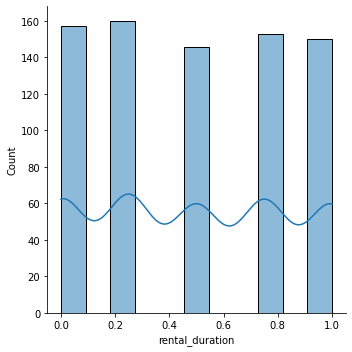

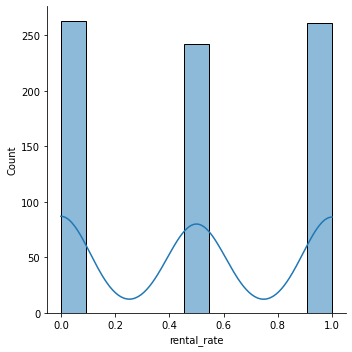

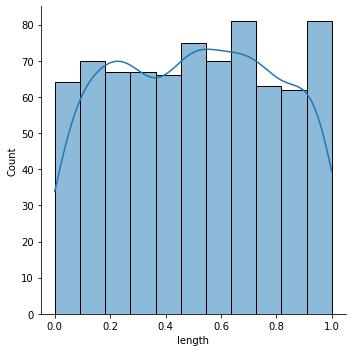

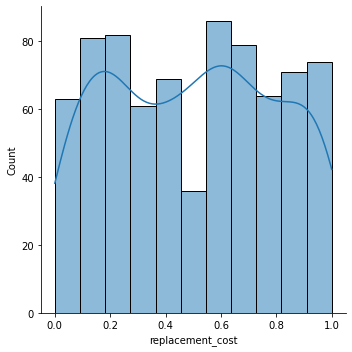

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for columns in X_train_norm.columns:
    sns.displot(X_train_norm[columns], kde = True)
    plt.show()

In [ ]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                multi_class='multinomial').fit(X_train_transformed, y_train)

#### For the test set

In [ ]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)